# Imports

In [2]:
import warnings
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold

from dstoolkit.automl.classifier import AutoMLCatBoost, AutoMLCatBoostCV

In [3]:
warnings.filterwarnings("ignore")

## Functions

In [4]:
def generate_synthetic_binary_data(
    n_samples=10000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,
    flip_y=0.15,
    weights=[0.8, 0.2],
    test_size=0.2,
    valid_size=0.2,
    random_state=42
):
    """
    Gera uma base sintética binária com splits train/valid/test.
    Retorna: (X_train, y_train, X_valid, y_valid, X_test, y_test)
    """

    # ---------------------------
    # 1. Gerar base sintética
    # ---------------------------
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_classes=n_classes,
        class_sep=class_sep,
        flip_y=flip_y,
        weights=weights,
        random_state=random_state
    )

    # ---------------------------
    # 2. Train/Test
    # ---------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # ---------------------------
    # 3. Train/Validation
    # ---------------------------
    valid_relative = valid_size / (1 - test_size)

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train,
        test_size=valid_relative,
        stratify=y_train,
        random_state=random_state
    )

    y_train = pd.DataFrame(y_train, columns=['target'])
    y_valid = pd.DataFrame(y_valid, columns=['target'])
    y_test = pd.DataFrame(y_test, columns=['target'])
    
    return pd.DataFrame(X_train), y_train, pd.DataFrame(X_valid), y_valid, pd.DataFrame(X_test), y_test

# Data Base

In [5]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_synthetic_binary_data(
    n_samples=5000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,   # classes mais misturadas
    flip_y=0.15,     # ruído nos rótulos
    weights=[0.8, 0.2],  # desbalanceamento
    test_size=0.2,
    valid_size=0.2,
    random_state=42
)


# Modeling

## CatBoost

In [7]:
cat = AutoMLCatBoost(scoring='log_loss', tune=True, n_trials=20)
cat.train(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [8]:
cat.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train,0.930122,1.000000,0.860244,0.924872,0.999550,0.980780,0.031497,0.153254
Valid,0.729112,0.802632,0.497959,0.614610,0.822052,0.522341,0.121089,0.396294
Test,0.728203,0.762195,0.508130,0.609756,0.808366,0.522622,0.125721,0.414464


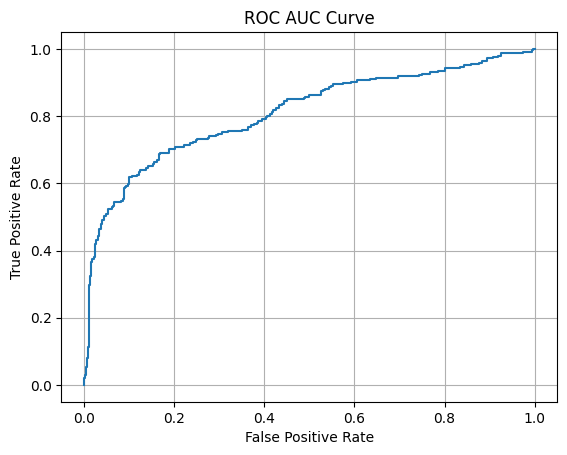

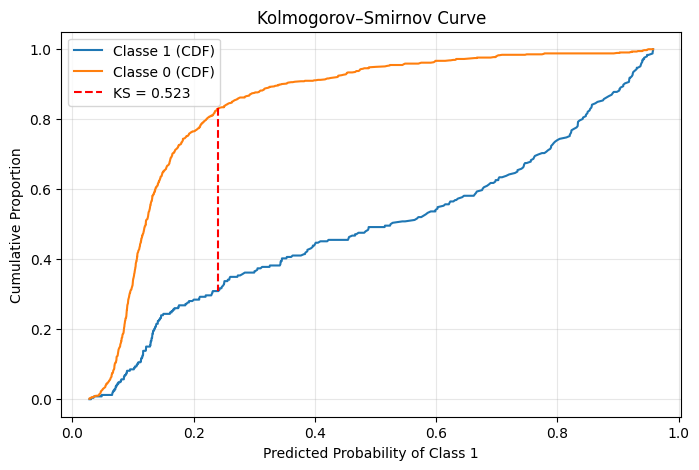

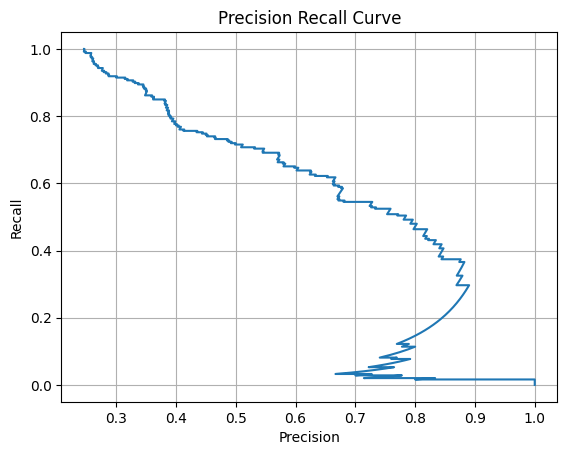

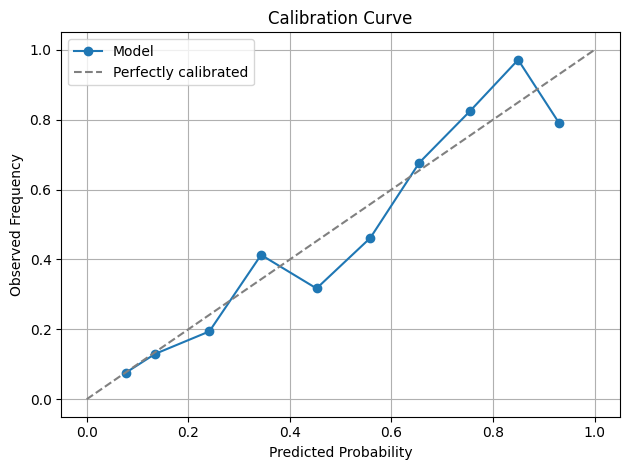

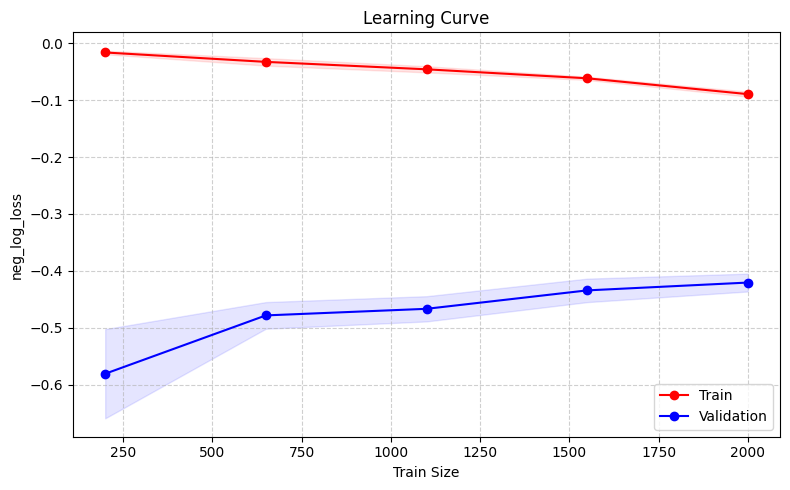

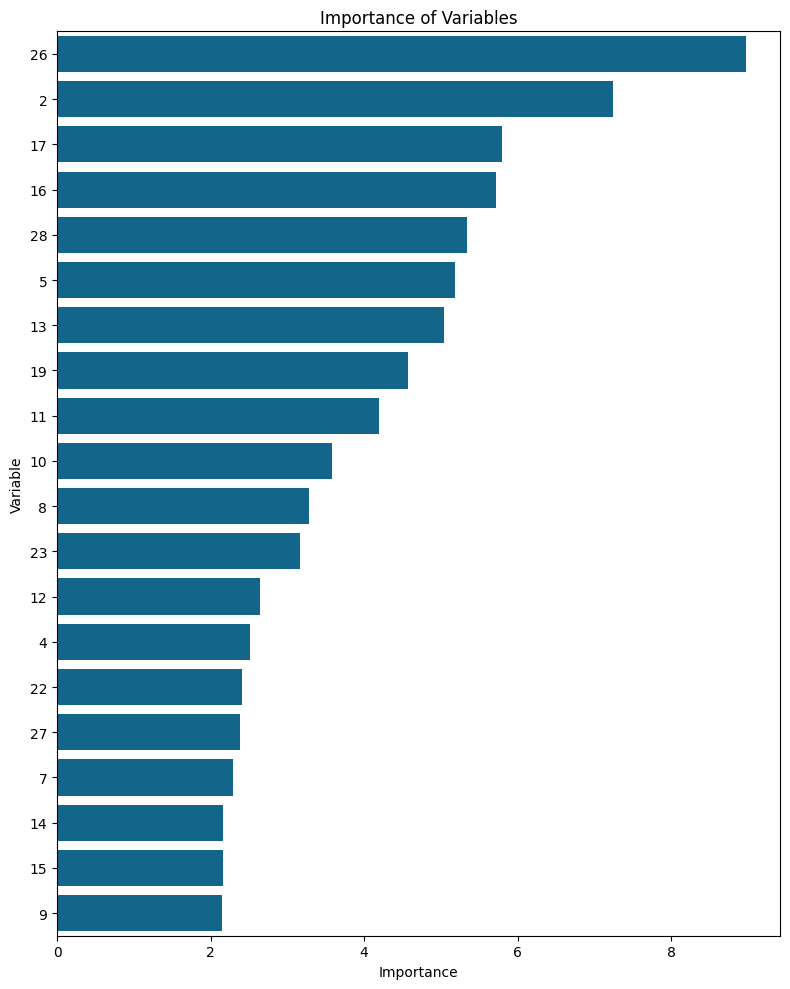

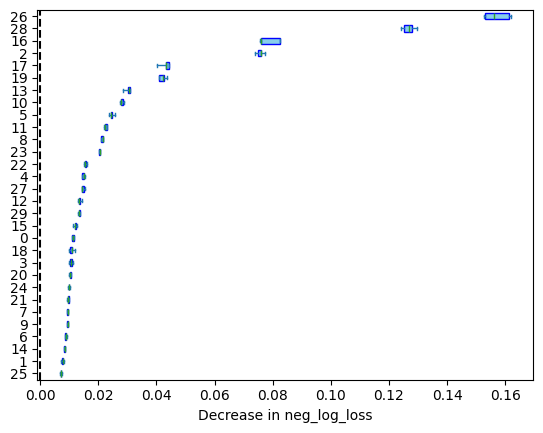

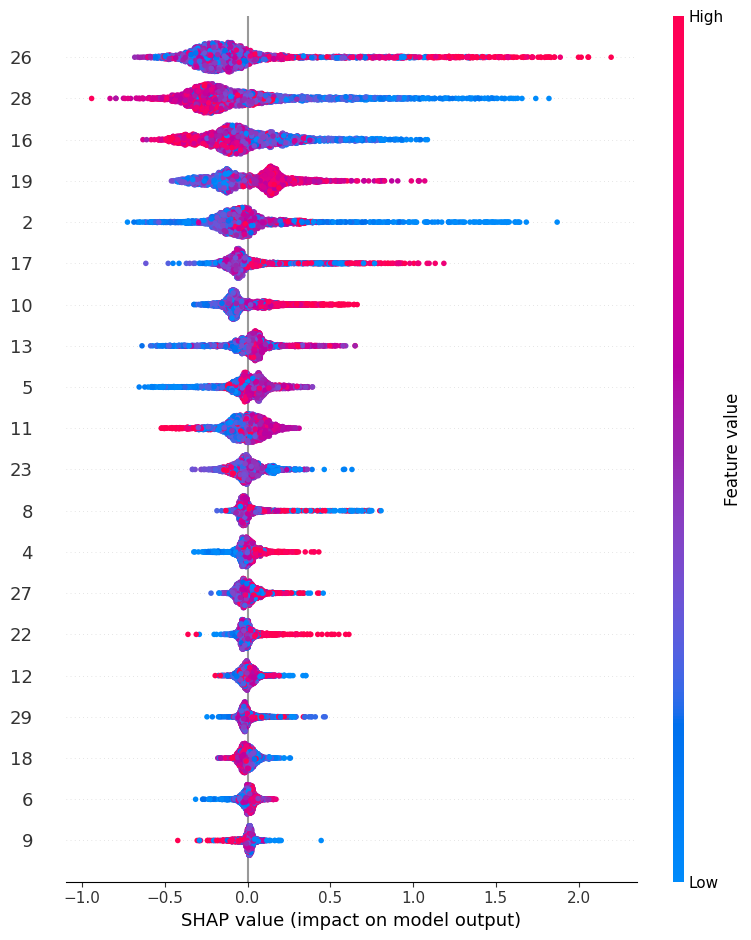

In [9]:
cat.analyze()

## CatBoost CV

In [10]:
cat_cv = AutoMLCatBoostCV(scoring='log_loss', tune=True)
cat_cv.train(X_train, y_train, X_test, y_test)

In [11]:
cat_cv.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train CV,0.696257,0.794032,0.428748,0.556768,0.813911,0.529404,0.126442,0.411505
Test,0.724138,0.759259,0.500000,0.602941,0.815623,0.531647,0.125337,0.409936


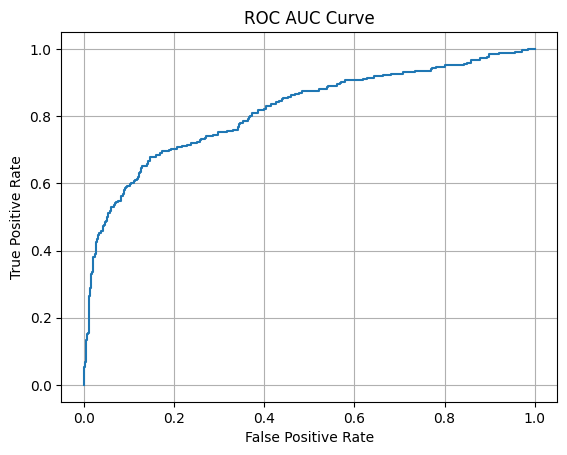

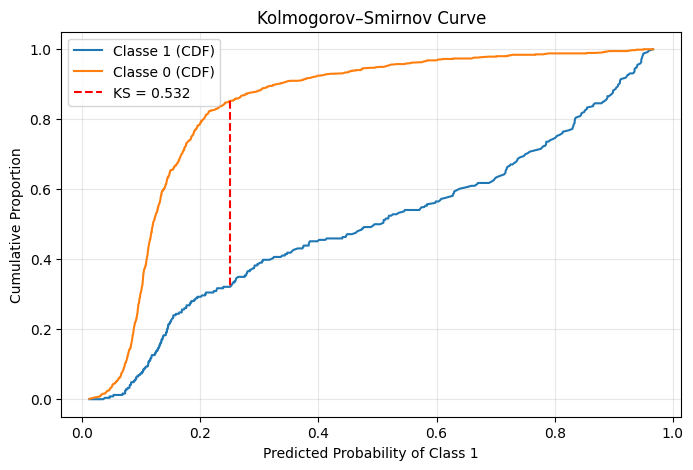

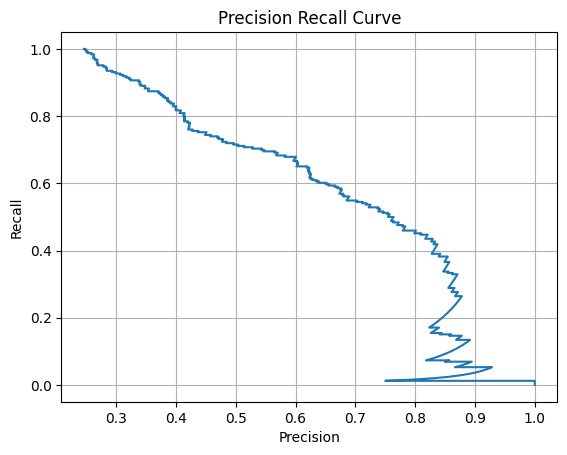

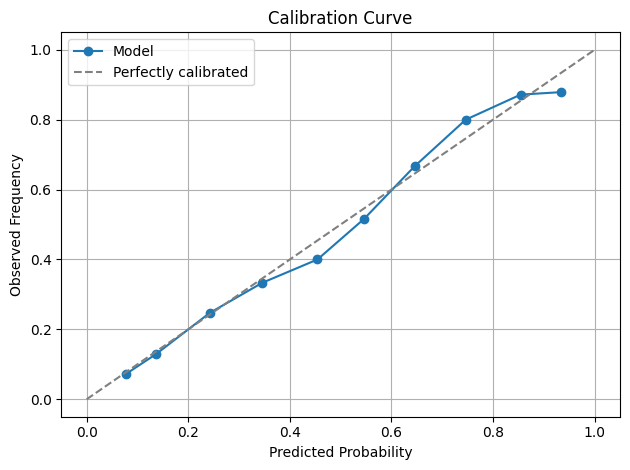

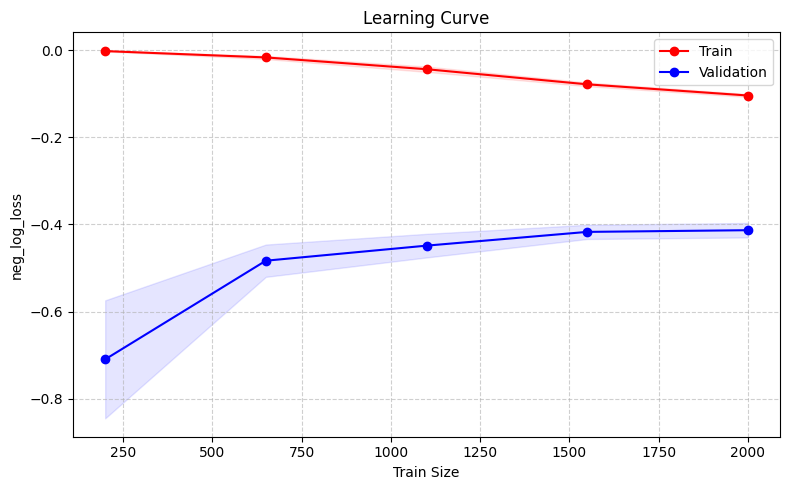

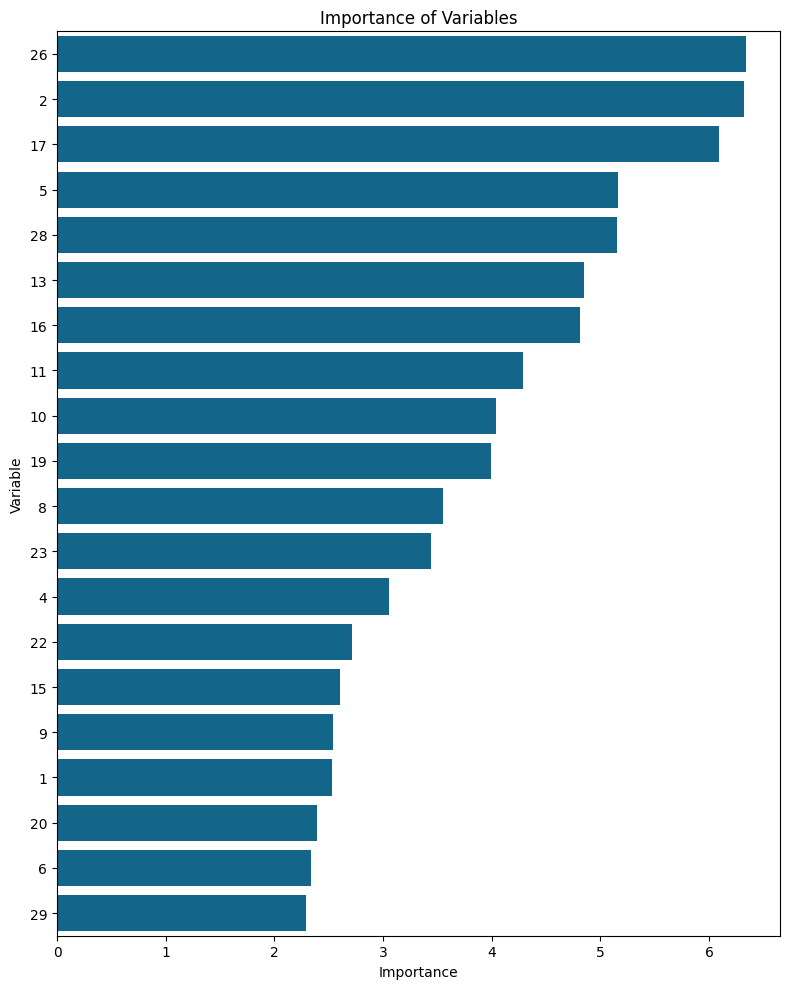

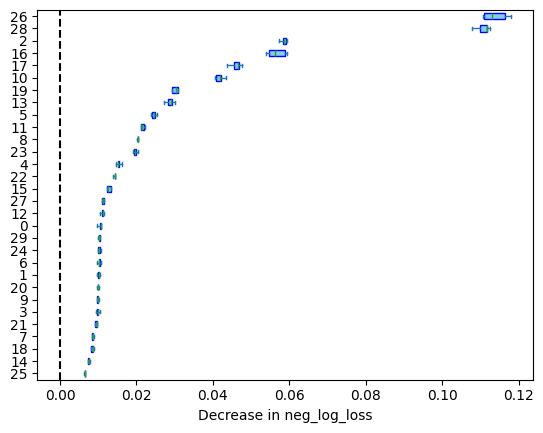

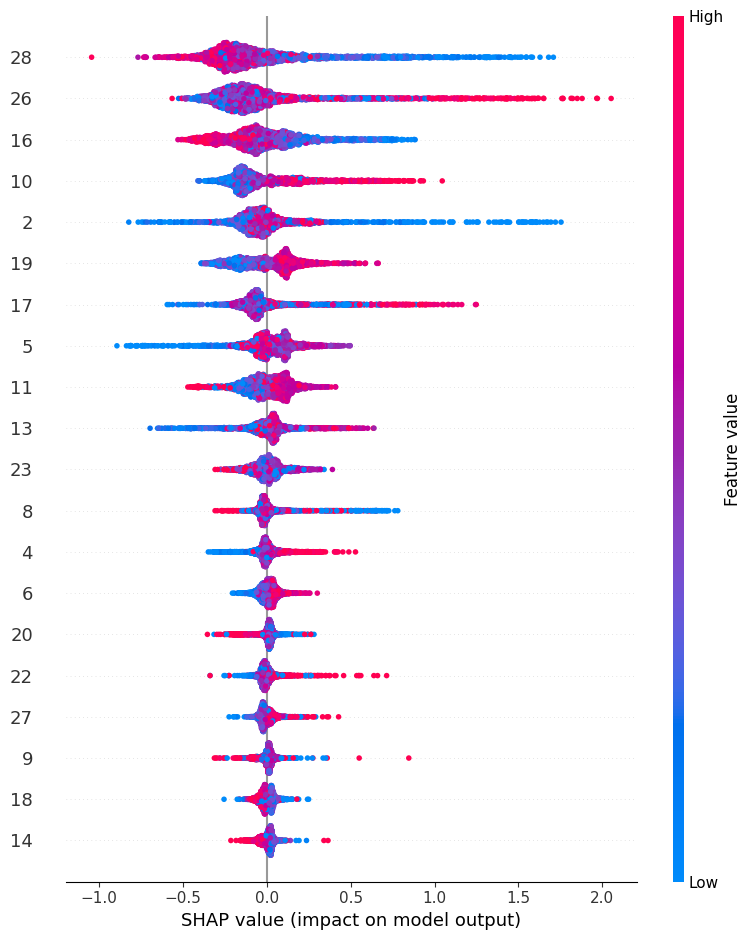

In [12]:
cat_cv.analyze()